In [1]:
import scvelo as scv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import scanpy as sc
import csv as csv
import cellrank as cr

In [ ]:
#Load concatenated loom file and integrated single cell .h5ad file

loom = scv.read("/hpc/pmc_kool/fvalzano/Jupyter/scvelo/Ependymoma/Timepoints/timepoints.loom")
scrna = scv.read("/hpc/pmc_kool/fvalzano/Jupyter/scvelo/Ependymoma/Timepoints/scrna_timepoints.h5ad")

In [ ]:
#Merge single cell object and loom file in a new velocity object that will store information regarding spliced and unspliced RNA in the velocity object and single cell data
scrna_velocity = scv.utils.merge(scrna, loom)
scrna_velocity.obs

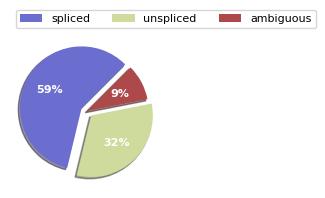

In [9]:
#Convert timepoints metadata slot in a character
scrna_velocity.obs['timepoints_chr'] = scrna_velocity.obs['timepoint'].map({0:'11d',
                                                                             1:'d30',
                                                                             2:'d44',
                                                                             3:'d80'})
scv.pl.proportions(scrna_velocity, groupby= "timepoint_chr")

In [ ]:
#Run scvelo
scv.pp.filter_and_normalize(scrna_velocity, min_shared_counts=20, n_top_genes=4000)
scv.pp.moments(scrna_velocity, n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(scrna_velocity)
scv.tl.velocity(scrna_velocity, mode='dynamical')
scrna_velocity

In [ ]:
#Plot velocity results
scv.tl.velocity_graph(scrna_velocity)
scv.pl.velocity_embedding_grid(scrna_velocity, basis='umap', color='timepoint', arrow_length=1.5, dpi=150, palette=['#954536', '#cfa486', '#cf9e98', '#197da5'], save="Timepoints_velocity_grid.svg")

In [ ]:
#Plot top fitted velocity genes sorted by fit likelihood score
top_genes = scrna_velocity.var["fit_likelihood"].sort_values(ascending=False).index[:10]
plt.hist(scrna_velocity.var['fit_likelihood'])
scv.pl.scatter(scrna_velocity, var_names=top_genes, color="timepoint")

In [13]:
#How many velocity genes?
scrna_velocity.var['velocity_genes'].sum()

638

In [ ]:
#Compute root and end state based on latent time
scv.tl.terminal_states(scrna_velocity)
scv.tl.latent_time(scrna_velocity)
scv.pl.scatter(scrna_velocity, color='latent_time', color_map='gnuplot', size=10)
scv.pl.scatter(scrna_velocity, color=[ 'root_cells', 'end_points'], save="Timepoints_Root_and_End_points.svg")

In [ ]:
#Find genes changing along the transdifferentiation trajectory highlighted by RNAvelocity
top_genes = scrna_velocity.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(scrna_velocity, var_names=top_genes, sortby='latent_time', col_color='timepoint', palette=['#954536', '#cfa486', '#cf9e98', '#197da5'], save="Heatmap_Velocity_genes.svg")

In [18]:
#Extract heatmap rows (genes)
xkey = 'Ms'
tkey = 'latent_time'
n_convolve = 30

var_names = top_genes[:300]

time = scrna_velocity.obs[tkey].values
time = time[np.isfinite(time)]

df = pd.DataFrame(scrna_velocity[:, var_names].layers[xkey][np.argsort(time)], columns=var_names)

if n_convolve is not None:
    weights = np.ones(n_convolve) / n_convolve
    for i, gene in enumerate(var_names):
        df[gene] = np.convolve(df[gene].values, weights, mode='same')

max_sort = np.argsort(np.argmax(df.values, axis=0))
top_genes_ordered = top_genes[max_sort]

with open('top_genes_ordered.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([top_genes_ordered])

In [ ]:
#Investigate single genes
scv.pl.velocity(scrna_velocity, ["STMN2"], color='timepoint')
scv.pl.scatter(scrna_velocity, x='latent_time', y='STMN2', frameon=False, use_raw=False, color='timepoint')

In [ ]:
#Calculate velocity pseudotime 
scv.tl.velocity_pseudotime(scrna_velocity)
scv.pl.scatter(scrna_velocity, color='velocity_pseudotime', cmap='gnuplot')
scv.pl.velocity_embedding_grid(scrna_velocity, basis='umap', color='velocity_pseudotime', arrow_length=1.5, dpi=150, cmap='gnuplot')

In [ ]:
sc.pl.violin(scrna_velocity, groupby='seurat_clusters', keys="velocity_pseudotime" frameon=True, use_raw=False, color="timepoint")